# Stock Sentiment Prediction using News Headline Data

We are attempting to assign sentiment to 1226258 news headlines from a leading australian news outlet, using this in combination with geospatial data providing intelligence for stock trading decisions, including using the sentiment data as input into a naive stock prediction of a australian ETF. 

It is worth noting we are not the first to think of or attempt this:

    - Hedge funds already use sentiment scores from news outlets to inform high frequency trading
    - Academic research has shown there is a existant correlation (albiet weak) between sentiment and individual stocks 
    - Several companies flagship product is news sentiment data for sale to the financial market 
    
    https://www.nature.com/articles/s41598-021-82338-6
    http://infotrie.com/finsents/
    https://stocksnips.net/

In [8]:
# import time
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure

import nltk

from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

import multiprocessing

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
from spacy import displacy
from textacy import preprocessing

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans

# Load and Inspect data
We are 

Ill come back to this to make it scaleable - ben 

In [2]:
news = pd.read_csv('abcnews-date-text.csv', parse_dates=['publish_date'] )
news.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


## Light EDA to Scope out our data

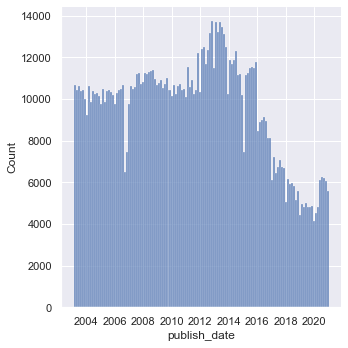

In [69]:
# lets get a sense for when these articles were published
sns.set(rc = {'figure.figsize':(15,8)})
sns.displot(data=plot_news, x= 'publish_date')

In [57]:
plot_news = news.copy()

# Create a column that is the length of our headlines
plot_news['Avg_length'] = plot_news["headline_text"].apply(lambda x: np.mean([len(w) for w in x.split()]))

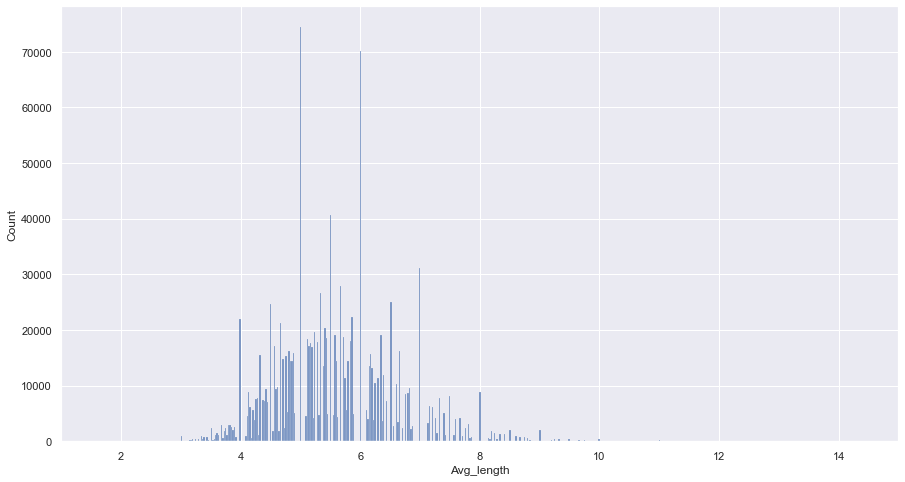

In [65]:
sns.set(rc = {'figure.figsize':(15,8)})
fig, ax = plt.subplots()
ax.set_xlim(1, 15)
sns.histplot(data=plot_news, x='Avg_length', kind = 'kde')

# Clean and Preprocess data

This data is already remarkably clean, in large part because it came from news headlines which are unlikely to have typos, partial words, or non standard characters such as emojis or HTML artifacts

In [9]:
def textacy_preprocess(messy_data):
    """
    Takes a dataframe and runs headline_text column through 
    textacy preprocessing pipeline and punctuation removing regex
    """
    cleaned_titles=[]
    #lets define a textacy preprocessing pipline that takes care of many basic regex operations for us 
    preproc = preprocessing.make_pipeline(
        preprocessing.replace.hashtags,
        preprocessing.replace.user_handles,
        preprocessing.replace.emojis,
        preprocessing.normalize.hyphenated_words,
        preprocessing.normalize.quotation_marks,
        preprocessing.remove.punctuation
    )

    for headline in messy_data['headline_text']:
        # Litte regex to remove any punctuation that textacy might miss
        headline = re.sub(r"[^A-Za-z0-9 ]",'',headline)
        cleaned_titles.append(preproc(headline))
        
    messy_data["headline_text"] = cleaned_titles 
    return(messy_data)

In [10]:
cleaned_news = textacy_preprocess(news)

## Mordecai
Mordecai is a geospatial library that maps references in unstructred free text to ISO geographic information
from https://github.com/openeventdata/mordecai 

   - It uses spaCy's named entity recognition to extract placenames from the text.
   
   
   - It uses the geonames gazetteer in an Elasticsearch index (with some custom logic) to find the potential coordinates of extracted place names.
   
- It uses neural networks implemented in Keras and trained on new annotated English-language data labeled with Prodigy to infer the correct country and correct gazetteer entries for each placename.



In order to work, Mordecai needs access to a Geonames gazetteer running in Elasticsearch. I have provided a dockerfile and Makefile that can implement this, though it is very slow, so I would reccomend skipping running this python file and using the sample I generated letting it run overnight


Usage: in top level directory:
1. Create a virtual enviroment (Note: It's strongly recommended that you run Mordecai in a virtual environment. The libraries that Mordecai depends on are not always the most recent versions and using a virtual environment prevents libraries from being downgraded or running into other issues:)
2. `pip3 install mordecai` (In virtual env)
3. `make develop` 
2. `python geoparsing.py` or run magic cell below

In [61]:
%run geoparsing.py

ModuleNotFoundError: No module named 'mordecai'

In [ ]:
# read in mordecai sample we produced offline
mordecai_news = pd.read_csv('abcnews-date-text-mordecai_part_300000.csv')

# Unsupervised Sentiment Analysis
In real world applications we are not always lucky enough to have to labeled data or have the time/resources to label a sufficient portion, 

For sentiment analysis there are several approaches that we will compare: 

    - CLustering Approach (https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483) 
    
    - Vader (https://medium.com/analytics-vidhya/sentiment-analysis-with-vader-label-the-unlabeled-data-8dd785225166)
    
    - BERT (https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
        
  
Lets make sure to make scores go between -1 and 1 so we can compare across methodologies 

## Bert

In [9]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', "distilbert-base-uncased-finetuned-sst-2-english")

In [10]:
classifier('cemeteries miss out on funds')

[{'label': 'NEGATIVE', 'score': 0.9995111227035522}]

In [12]:
# Bert sentiment classifier is extrodinarily easy, but slow, we will use this opportuynity for a state save and will write
# the dataframe to disk with the sentiment 
confidence = []
for headline in news['headline_text']:
    confidence.append(classifier('country_predicted'))
news['BERT_sentiment'] = confidence

# lets write out the dat
## news.to_csv('abcnews-date-text_bert.csv')

## K-means method 

An alternative to BERT is a very unusual method that uses K-means on embeddings to group our words into two clusters, we then use a heuristic to assign reasonable sentiment labels to the two clusters as eithier positive or negative words, we can then generate the sentiment of a given vector by taking the average of the word sentiment scores. 

I hypothesize this may work well for our particular dataset due to the domain specific language in news, and the many references to entities that may not appear often in other text. 

Cons of this approach: 
    - We treat our inferred labels as ground truth when creating our classification model
    - We end up with a bag of words model, since we average the vector to get a headline sentiment score
    
    
Inspired by:https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483



### Tokenize our Titles
Be sure to only use the tokenize function of spacy to save on compute

In [11]:
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.tokenizer
tokens = []
# for each headline lets tokenize the sentence
for doc in cleaned_news['headline_text']: 
    temp_tokens = tokenizer(doc)
    title_tokens = []
    # now lets break the sentence into indivual tokens
    for token in temp_tokens:
        title_tokens.append(token.text)
    tokens.append(title_tokens)
tokens

[['aba', 'decides', 'against', 'community', 'broadcasting', 'licence'],
 ['act', 'fire', 'witnesses', 'must', 'be', 'aware', 'of', 'defamation'],
 ['a', 'g', 'calls', 'for', 'infrastructure', 'protection', 'summit'],
 ['air', 'nz', 'staff', 'in', 'aust', 'strike', 'for', 'pay', 'rise'],
 ['air', 'nz', 'strike', 'to', 'affect', 'australian', 'travellers'],
 ['ambitious', 'olsson', 'wins', 'triple', 'jump'],
 ['antic', 'delighted', 'with', 'record', 'breaking', 'barca'],
 ['aussie', 'qualifier', 'stosur', 'wastes', 'four', 'memphis', 'match'],
 ['aust', 'addresses', 'un', 'security', 'council', 'over', 'iraq'],
 ['australia', 'is', 'locked', 'into', 'war', 'timetable', 'opp'],
 ['australia', 'to', 'contribute', '10', 'million', 'in', 'aid', 'to', 'iraq'],
 ['barca', 'take', 'record', 'as', 'robson', 'celebrates', 'birthday', 'in'],
 ['bathhouse', 'plans', 'move', 'ahead'],
 ['big', 'hopes', 'for', 'launceston', 'cycling', 'championship'],
 ['big', 'plan', 'to', 'boost', 'paroo', 'water',

In [12]:
# This will log our log loss which will be very useful for picking number of epochs strange to me its not default behavior
# callback class inspired by https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

### Buid our model, define the vocab, and train it on our corpus

We will create a word2vec model to train our embeddings specific to our corpus

**Hyper Paramater Choices**

    - We want complex embeddings since our headlines are short so we will choose 300 for size,

    - We dont want words that only appear once for sparsity reasons so we set our min_count to 3 
    
    - Fairly large alpha that decays to 0.0007 which hopefully will work well many short documents that may be repitious

    - We also want a relatively small window because our headlines are so short also because we dont want a very domain specific embedding per: 


*some research has suggested that using a larger window tends to position the final vectors in a way that's more sensitive to topical/domain similarity, while a smaller window value shifts the word-neighborhoods to be more syntactic/functional drop-in replacements for each other.*



In [13]:
%%time 
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(tokens, progress_per=50000)
w2v_model.train(tokens, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1, compute_loss=True, 
                     callbacks=[callback()])


Loss after epoch 0: 828865.625
Loss after epoch 1: 796620.25
Loss after epoch 2: 750106.375
Loss after epoch 3: 697380.0
Loss after epoch 4: 681187.25
Loss after epoch 5: 597405.5
Loss after epoch 6: 505637.5
Loss after epoch 7: 483681.0
Loss after epoch 8: 542361.0
Loss after epoch 9: 498355.0
Loss after epoch 10: 498202.5
Loss after epoch 11: 424903.5
Loss after epoch 12: 450024.0
Loss after epoch 13: 455409.5
Loss after epoch 14: 499730.0
Loss after epoch 15: 460938.0
Loss after epoch 16: 455596.0
Loss after epoch 17: 424857.0
Loss after epoch 18: 453123.0
Loss after epoch 19: 455859.0
Loss after epoch 20: 422704.0
Loss after epoch 21: 441647.0
Loss after epoch 22: 409431.0
Loss after epoch 23: 409963.0
Loss after epoch 24: 381110.0
Loss after epoch 25: 421307.0
Loss after epoch 26: 438479.0
Loss after epoch 27: 424387.0
Loss after epoch 28: 396021.0
Loss after epoch 29: 415686.0
Wall time: 1min 45s


(88628323, 241046820)

### Retrain with fewer epochs 

In [14]:
# we can observe a "jittering" of loss up and down starting after around epoch 8, so we will set our epochs to 7 to be safe
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers=multiprocessing.cpu_count()-1)

w2v_model.build_vocab(tokens, progress_per=50000)

w2v_model.train(tokens, total_examples=w2v_model.corpus_count, epochs=8, report_delay=1, compute_loss=True, 
                     callbacks=[callback()])
w2v_model.save('word2vec.model')

Loss after epoch 0: 855117.3125
Loss after epoch 1: 778662.8125
Loss after epoch 2: 783383.625
Loss after epoch 3: 732482.25
Loss after epoch 4: 718728.0
Loss after epoch 5: 619702.0
Loss after epoch 6: 565409.0
Loss after epoch 7: 552642.0


### Run our embeddings through KMeans to find similar words

While kmeans cannot accept different distance metrics, we can simply normalize our vectors which then makes euclidean distance proporional to cosine distance 
https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python

In [22]:
# snag our word embeddings from our word2vec model  
word_vectors= w2v_model.wv

#create a two cluster kmeans that we will use to assign initial sentiment 
km = KMeans(n_clusters=2, max_iter=500, random_state=True, n_init=50).fit(X=\
                                                sklearn.preprocessing.normalize(word_vectors.vectors.astype('double')))

#grab the top words from the index 1 cluster
word_vectors.similar_by_vector(km.cluster_centers_[1], topn=30, restrict_vocab=None)

[('nationally', 0.9961749911308289),
 ('economically', 0.9958812594413757),
 ('calderwood', 0.9953569769859314),
 ('dividing', 0.9950661659240723),
 ('submitted', 0.9944886565208435),
 ('wastage', 0.9944350719451904),
 ('foodbowl', 0.994354248046875),
 ('detrimental', 0.9942970871925354),
 ('homelands', 0.9936981797218323),
 ('fortnightly', 0.9935835599899292),
 ('amalgamate', 0.993540346622467),
 ('electranet', 0.9935305714607239),
 ('accomodation', 0.9935132265090942),
 ('biosolids', 0.9933958053588867),
 ('enhanced', 0.9933798313140869),
 ('contributors', 0.993369996547699),
 ('redirected', 0.9933401942253113),
 ('kangaloon', 0.9933239817619324),
 ('supplementary', 0.9932680726051331),
 ('vcoss', 0.9932526350021362),
 ('infill', 0.9932491183280945),
 ('freehold', 0.9931695461273193),
 ('hwe', 0.9930689930915833),
 ('sanitary', 0.9929832816123962),
 ('glitches', 0.992636501789093),
 ('commercially', 0.9925680160522461),
 ('dnr', 0.992497980594635),
 ('problematic', 0.9924957156181335

In [24]:
word_vectors.similar_by_vector(km.cluster_centers_[0], topn=20, restrict_vocab=None)

[('salma', 0.9982630014419556),
 ('witches', 0.9981409907341003),
 ('flattered', 0.9981108903884888),
 ('ranting', 0.9980683922767639),
 ('mandy', 0.9980679154396057),
 ('priebus', 0.9980022311210632),
 ('nicki', 0.9979618787765503),
 ('bookstores', 0.9979469776153564),
 ('pal', 0.997905969619751),
 ('blackburns', 0.9978662133216858),
 ('zebras', 0.9978460669517517),
 ('reince', 0.9977982640266418),
 ('trolled', 0.9977729320526123),
 ('charlize', 0.9977412819862366),
 ('seamus', 0.9977098107337952),
 ('gero', 0.9976457357406616),
 ('domingo', 0.997614324092865),
 ('blond', 0.9976021647453308),
 ('griezmann', 0.997589111328125),
 ('tussauds', 0.9975794553756714)]

## Assign sentiment to clusters

This is a significantly hard heursitic to apply, as neithier clusters top words are overwhelmingly positive or negative, I have two theories for this, firstly the formal language of news is intrinsically non-partisan, secondly the distances are so close (top 20 all > 99.6) we can also see that these are not general words, indeed they are very specific. 

Despite all this, the index cluster 1 seems to be more negative (problematic,crippling,detrimental) than index 0

In [26]:
positive_cluster_index = 0
positive_cluster_center = km.cluster_centers_[positive_cluster_index]
negative_cluster_center = km.cluster_centers_[1-positive_cluster_index]


In [27]:
# Create a dataframe to map KMeans cluster labels to words
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: km.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])


In [28]:
# Apply sentiment score as function of the words closeness to the centroid
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(km.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

sent_dict = words[['words', 'sentiment_coeff']].values

In [48]:
sent_dict = dict(sent_dict)
sent_dict

{'to': -0.27877941674470785,
 'in': 0.42047542474808824,
 'for': -0.32205798513028455,
 'of': 0.40814534169486477,
 'on': -0.461044929667621,
 'the': 0.37544241367736936,
 'over': 0.3162248275135506,
 'police': 0.2527767120552989,
 'at': 0.48648335182832264,
 'with': 0.4037201700941474,
 'after': 0.3676406369912481,
 'new': -0.4514102839890369,
 'man': 0.23308390690394154,
 'a': 0.3934428456735228,
 'and': 0.450484024801153,
 'as': 0.4126300411192354,
 'says': -0.33714394827725985,
 'from': 0.5192206607218054,
 'up': -0.4153852913373491,
 'by': 0.4571276492702987,
 'us': 0.2880429706188237,
 'out': 0.41352122187445695,
 'court': 0.2585718343804253,
 'be': -0.3360354480217852,
 'govt': -0.31395869115473557,
 'council': -0.2770179661749154,
 'more': -0.35462874481243184,
 'australia': 0.3505978863597092,
 'nsw': -0.3604229760439678,
 'not': -0.3379208234104048,
 'interview': 0.17400803996435488,
 'fire': -0.2825822111345321,
 'nt': -0.29918250593833595,
 'australian': 0.42629763321120945

## TF-IDF 
This method relies on assigning similarity for each document with the doc product of its tf-idf matrix and the inffered sentiment from the KMeans clustering, now we construct the TFIDF matrix and find the value for each unque word

In [57]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, norm=None)
tfidf.fit(cleaned_news['headline_text'])
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(cleaned_news['headline_text'])



C:\Users\drpow\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [58]:
def create_tfidf_dictionary(x, transformed_file, features):
    """""
    Each input document is assigned a dictionary with sentiment for all tokens
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    """""
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    """""
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """""
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], word_tokenize(x.headline_text)))



In [59]:
replaced_tfidf_scores = cleaned_news.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

In [30]:
def replace_sentiment_words(word, sentiment_dict):
    '''Lookup Sentiment for a given word, if out of vocab, reuturn 0'''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [54]:
# replace each word with its adjusted sentiment score
all_sentiments=[]
for headline in cleaned_news['headline_text']: 
    headline_sent = []
    for word in word_tokenize(headline): 
        headline_sent.append(replace_sentiment_words(word, sent_dict))
    all_sentiments.append(headline_sent)

replaced_closeness_scores = pd.Series(all_sentiments)

Merge the sentiment and tfidf scores and compute the dot matrix for a final sentiment rate calculation

In [62]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, cleaned_news.headline_text]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')


AttributeError: 'DataFrame' object has no attribute 'sentiment'

In [65]:
replacement_df.head(5)

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
0,"[-1.1709900105044573, -0.6654634405530948, 0.3...","[11.049186715732196, 9.995598108438042, 5.6846...",aba decides against community broadcasting lic...,-11.411639,0
1,"[-0.4235783909495117, -0.2825822111345321, 0.2...","[6.286045662870665, 5.389047297004651, 8.12785...",act fire witnesses must be aware of defamation,-8.050290,0
2,"[0.3934428456735228, -0.332376021179608, -0.37...","[4.735091922585275, 8.488601001558433, 5.87463...",a g calls for infrastructure protection summit,-12.179778,0
3,"[-0.35678723784011607, 0.5850504709502775, -0....","[6.845339285854847, 6.954213420386585, 7.01611...",air nz staff in aust strike for pay rise,-9.358000,0
4,"[-0.35678723784011607, 0.5850504709502775, -0....","[6.845339285854847, 6.954213420386585, 6.79210...",air nz strike to affect australian travellers,-6.037280,0


In [64]:
replacement_df.to_csv('kmeans_sentiment_df.csv')

# Modeling stock prices 
I think we should choose a australian index, this one seems reasonable, but i dont think it matters very much, we are likely to get bad perfromance anwyays, just so long as it makes canonical sense 

https://www.ishares.com/us/products/239607/ishares-msci-australia-etf

Lets start with a super simple approach, did stop close up or down that day, that way we only have to deal with a binary classification problem, and if its >50 then we can say its technically better than random. 

We should note in our presentation that we want to make sure we outperform a buy and hold strategy aswell, if not, theres no point in using the model

Also that this would be one of many tools that an investment firm would use to make decisions. 

# References 

https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss
https://github.com/openeventdata/mordecai



@article{halterman2017mordecai,
  title={Mordecai: Full Text Geoparsing and Event Geocoding},
  author={Halterman, Andrew},
  journal={The Journal of Open Source Software},
  volume={2},
  number={9},
  year={2017},
  doi={10.21105/joss.00091}
}
